In [1]:
%matplotlib inline

from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from numpy.fft import fft2, ifft2, fftshift, fftfreq
from bruges.transform import time_to_depth, depth_to_time
from scipy.interpolate import CubicSpline, interp1d, interp2d
from scipy.signal import coherence
from ipywidgets import interact_manual, FloatSlider
from IPython.display import HTML, display

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<font size="6" color="red">The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</font>''')

### Defining our NMO correction functions
The functions nmo_correction, reflection_time, and sample_trace come courtesy of Leonardo Uieda and his geophysical tutorial "Step-by-step NMO correction" published in The Leading Edge.

doi: 10.1190/tle36020179.1

In [2]:
def nmo_correction(cmp, dt, offsets, velocities):
    """
    Performs NMO correction on the given CMP.
    
    The units must be consistent. E.g., if dt is seconds and
    offsets is meters, velocities must be m/s.
    
    Parameters
    ----------
    
    cmp : 2D array
        The CMP gather that we want to correct.
    dt : float
        The sampling interval.
    offsets : 1D array
        An array with the offset of each trace in the CMP.
    velocities : 1D array
        An array with the NMO velocity for each time. Should
        have the same number of elements as the CMP has samples.
        
    Returns
    -------
    
    nmo : 2D array
        The NMO corrected gather.
        
    """
    nmo = np.zeros_like(cmp)
    nsamples = cmp.shape[0]
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, x in enumerate(offsets):
            t = reflection_time(t0, x, velocities[i])
            amplitude = sample_trace(cmp[:, j], t, dt)
            # If the time t is outside of the CMP time range,
            # amplitude will be None.
            if amplitude is not None:
                nmo[i, j] = amplitude
    return nmo

In [3]:
def reflection_time(t0, x, vnmo):
    """
    Calculate the travel-time of a reflected wave.
    
    Doesn't consider refractions or changes in velocity.
        
    The units must be consistent. E.g., if t0 is seconds and
    x is meters, vnmo must be m/s.
    
    Parameters
    ----------
    
    t0 : float
        The 0-offset (normal incidence) travel-time.
    x : float
        The offset of the receiver.
    vnmo : float
        The NMO velocity.
        
    Returns
    -------
    
    t : float
        The reflection travel-time.
        
    """
    t = np.sqrt(t0**2 + x**2/vnmo**2)
    return t

In [4]:
def sample_trace(trace, time, dt):
    """
    Sample an amplitude at a given time using interpolation.
    
    Parameters
    ----------
    
    trace : 1D array
        Array containing the amplitudes of a single trace.
    time : float
        The time at which I want to sample the amplitude.
    dt : float
        The sampling interval
        
    Returns
    -------
    
    amplitude : float or None
        The interpolated amplitude. Will be None if *time*
        is beyond the end of the trace or if there are less
        than 2 points between *time* and the end.
        
    """
    # The floor function will give us the integer
    # right behind a given float.
    # Use it to get the sample number that is right
    # before our desired time.
    before = int(np.floor(time/dt))
    N = trace.size
    # Use the 4 samples around time to interpolate
    samples = np.arange(before - 1, before + 3)
    if any(samples < 0) or any(samples >= N):
        amplitude = None
    else:
        times = dt*samples
        amps = trace[samples]
        interpolator = CubicSpline(times, amps)
        amplitude = interpolator(time)
    return amplitude

In [5]:
def calc_angles(v_rms, time, x):
    '''
    Calculate the angle of incidence of an NMO corrected reflection.
    Ray-bending is not accounted for.
    
    Parameters
    ----------
    
    v_rms : RMS velocity at some point
    time : twt time from the gather
    x : offset
    '''
#     if type(v_rms).__module__ == np.__name__ && type(time).__module__ == np.__name__ && type(x).__module__ == np.__name__
    v_rms = np.array(v_rms)
    time = np.array(time)
    x = np.array(x)
    
    depth = v_rms * time
    angles = 90 - np.degrees(np.arctan(depth / x))
       
    return angles
    

### Dix Conversion Equation
We are going to want to use our stacking velocity to calculate interval velocities in order to estimate pressure. We are going to use the fact that, for small offsets, stacking velocities are very similar to RMS velocities. It is, however, important to remember that $V_{RMS} \neq V_{Stacking}$ everywhere, and that these differences can be important.

**Dix Equation Assumptions**
* Layer boundaries are flat
* The offsets range used in estimating the RMS velocities $V_{n}$ and $V_{n-1}$ corresponds to a small spread (i.e. short offsets)
* RMS velocities are calculated using a straight ray assuption, therefore ray-bending is not accounted for 

$$v_n = \sqrt{\frac{{V_n}^2 t_n - V_{n-1}^2 t_{n-1}}{t_n - t_{n-1}}}$$

In [7]:
def dix_eq(vrms, twt):
    int_vel = [np.sqrt((twt[i] * vrms[i]**2 - twt[i-1] * vrms[i-1]**2) / (twt[i] - twt[i-1])) for i in range(1,len(vrms))]
    return int_vel

In [8]:
# calc_angles(vnmo_corr_interp_savgol_filt, np.arange(0,len(vnmo_corr_interp_savgol_filt)), offsets)

#### Load in our synthetic CMP with known velocity model
Note: The geometrical spreading correction here was to simply multiply the CMP by TWT value

In [9]:
data = np.load(r'C:/Users/goril/OneDrive/_data/cmp_info_2200m.npz')
display(DataFrame(data.keys()).rename(index=str, columns={0: "Data in archive"}))

,Data in archive
0,velocity_model
1,density_model
2,offsets
3,cmp_orig
4,cmp_geom_sprd
5,dz
6,dt
7,reciever_loc
8,shot_loc
9,twt


In [10]:
# Setting variables from archive files

cmp_vel_mod = data['velocity_model']
cmp_orig = data['cmp_orig']
cmp_geom_sprd = data['cmp_geom_sprd']
cmp_density_mod = data['density_model']
dz = data['dz']
dt = data['dt']
shot_loc = data['shot_loc']
offsets = data['offsets']
reciever_loc = data['reciever_loc']
twt = data['twt']
vnmo_trials = data['vnmo_trials'] 
vnmo_trial_vels = data['vnmo_trial_vels']

# cmp_geom_sprd = cmp_orig * twt.reshape(len(twt), 1)

lim_geom = np.percentile(cmp_geom_sprd, 99)
lim_cmp = np.percentile(cmp_orig, 99)

### Let's plot up the geometrical spreading corrected CMP

In [54]:
dt * 2500

2.7173147139837295

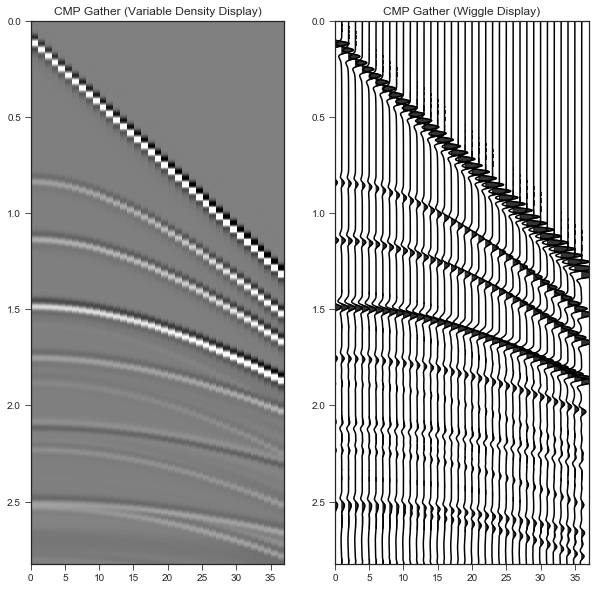

In [62]:
gain = 5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
titles = ['CMP Gather (Variable Density Display)', 'CMP Gather (Wiggle Display)']

extent = [0, cmp_geom_sprd.shape[1], twt.max(), 0]
ax[0].imshow(cmp_geom_sprd, aspect='auto', vmin=-lim_geom, vmax=lim_geom, cmap='gray', extent=extent)

for i,a in enumerate(ax):
    a.set_title(titles[i])   

for i in range(cmp_geom_sprd.shape[1]):
    ax[1].plot(cmp_geom_sprd[:,i] * gain + i, twt, c='k')
    ax[1].fill_betweenx(twt, i, cmp_geom_sprd[:,i] * gain + i, where=cmp_geom_sprd[:,i] * gain + i > i, 
                        color='k', alpha=0.8, interpolate=True)
    
ax[1].set_ylim(0,twt.max())
ax[1].set_xlim(0,cmp_geom_sprd.shape[1])
ax[1].invert_yaxis()


In [11]:
# list_new=[i for i in range(4)]


# # for i in range(4):
# #     list.append(i)
# list_new

### Now we will plot up the earth model this synthetic CMP came from

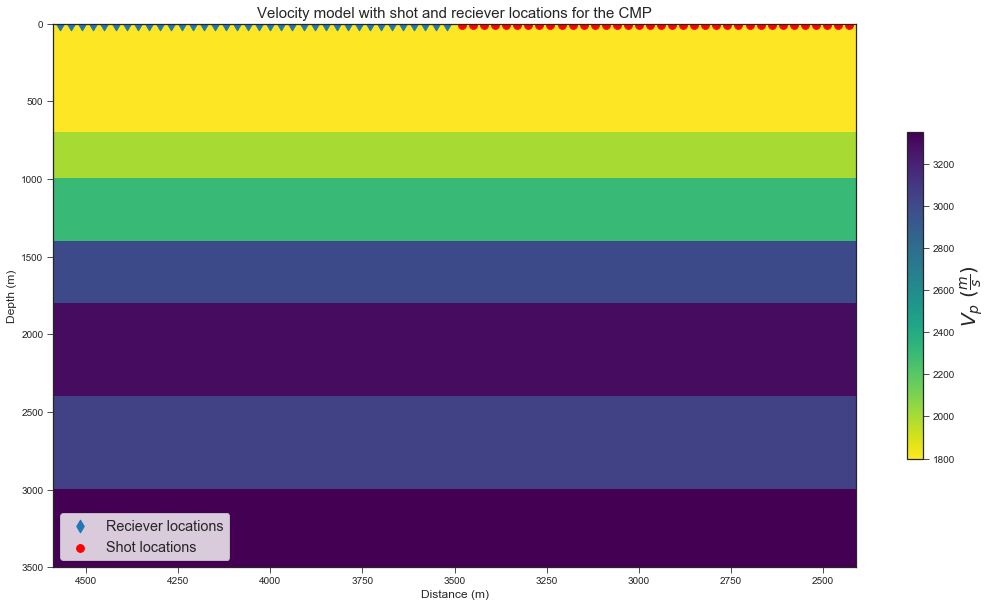

In [20]:
sns.set_style(style='ticks')

plt.figure(figsize=(18,10))
plt.scatter(reciever_loc * dz,np.ones_like(shot_loc), marker='d', s=80, label='Reciever locations')
plt.scatter(shot_loc * dz,np.ones_like(shot_loc)*10, s=60, color='r', label='Shot locations')
plt.xlim(reciever_loc.max() * dz - dz, shot_loc.min() * dz + dz)
plt.imshow(cmp_vel_mod, extent=[reciever_loc.max() * dz - dz, shot_loc.min() * dz + dz, 3500, 0], 
           aspect='auto', cmap='viridis_r')
plt.xlabel('Distance (m)', size=12)
plt.ylabel('Depth (m)', size=12)
plt.title('Velocity model with shot and reciever locations for the CMP', size=15)
cb = plt.colorbar(shrink=0.6)
cb.set_label(label=r'$V_p \ (\frac{m}{s})$', weight='bold', size=20)
plt.legend(loc='lower left', fancybox=True, facecolor='w', frameon=True, fontsize='x-large')

In [13]:
def vel_mod():
    interface_depths = [0, 700, 1000, 1400, 1800, 2400, 3000]
    int_vels = [1800, 2000, 2300, 3000, 3300, 3050, 3350]
    layer_diff = np.diff(interface_depths)
    twt_vel_mod_1 = np.cumsum([(l * 2) / v for v,l in zip(int_vels,layer_diff)])
    twt_vel_mod_1 = np.insert(twt_vel_mod_1,0,0.)
    twt_vel_mod = [reflection_time(twt_vel_mod_1[i],offsets[0], v) for i,v in enumerate(int_vels)]
    shape=(3500,)
    velocity = np.zeros(shape)
    for d,v in zip(interface_depths, int_vels):
#         velocity[int(d // 10):,:] = v
        velocity[d:] = v
    return velocity, twt_vel_mod

### A library of gathers corrected for different constant Vnmo values.

The data archive we loaded contained two items called "vnmo_trial_vels" and "vnmo_trials." These refer to a list of some constant test velocities and an array of the resulting corrected CMP gathers corrected with each velocity. 
We will use this library to do our stacking velocity analysis.

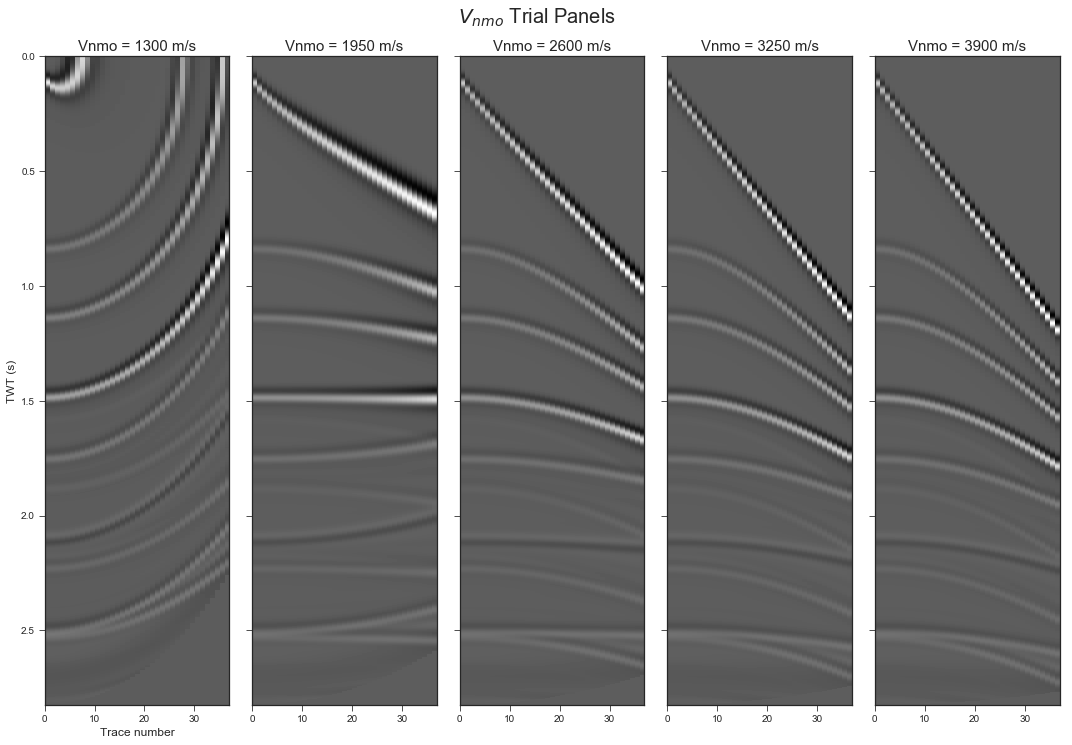

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,10), sharey=True, sharex=True)

for i,j in enumerate(range(0,vnmo_trials.shape[0],vnmo_trials.shape[0] // 4)):
    ax[i].imshow(vnmo_trials[j], aspect = 'auto', cmap='gray', extent=extent)
    ax[i].set_title(f'Vnmo = {vnmo_trial_vels[j]} m/s', size=15)
   
fig.suptitle(r'$V_{nmo}$ Trial Panels', y=1.03, size=20)
ax[0].set_ylabel('TWT (s)', size=12)
ax[0].set_xlabel('Trace number', size=12)
plt.tight_layout()

### We can stack each of the above panels into a single trace to better determine which velocities  best flatten certain reflections reflections.

In [63]:
def basic_semblance(vnmo_trials):
    sq_sum = np.array([np.sum(vnmo, axis=1)**2 for vnmo in vnmo_trials])
    summed_sqs = np.array([np.sum(vnmo**2, axis=1) for vnmo in vnmo_trials]) 
    n = vnmo_trials.shape[2]

    semblance = (sq_sum / summed_sqs) / n
    
    return semblance.T


$$semblance = \frac{\bigg( \sum_{i=1}^N a_i \bigg)^2}{N \sum_{i=1}^N a_i^2}$$

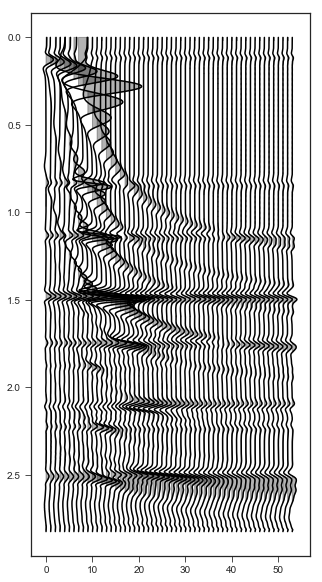

In [64]:
plt.figure(figsize=(5,10))
for i,v in enumerate(vnmo_trials):
    plt.plot(np.sum(v, axis=1)+i, twt, color='k')
    plt.fill_betweenx(twt,i,np.sum(v, axis=1)+i,where=np.sum(v, axis=1)+i > i, 
                      color='k', alpha=0.3, interpolate=True)
plt.gca().invert_yaxis()


In [73]:
sem_start = np.array([np.sum(v, axis=1) for v in vnmo_trials])
sns.set_style(style='whitegrid')

def interact_plot(v0,v1,v2,v3,v4,v5,v6,v7):
    
    real_vel, twt_vel_mod = vel_mod()
    real_vel_twt, t_basis = depth_to_time(real_vel, real_vel, dz=1, dt=dt, return_t=True)
    real_vel_twt = real_vel_twt[:cmp_geom_sprd.shape[0]]
    t_basis = t_basis[:cmp_geom_sprd.shape[0]]
    
    gain = 8
    titles = ['CMP Gather', 'Semblance Plot', 'NMO Corrected Gather', 'Stacked NMO Corrected Gather']
    x_labels = ['Trace number', r'$V_{nmo}$', 'Trace number', 'Amplitude']
    
    vnmo_user = np.array([v0,v1,v2,v3,v4,v5,v6,v7])
    f1 = interp1d(np.append(twt_vel_mod, twt.max()),
                  vnmo_user, 
                  fill_value='extrapolate', kind='cubic')
    vnmo_usr_interp = f1(twt)
    c = basic_semblance(vnmo_trials)
    
    dix_vint = dix_eq(vnmo_user, np.append(twt_vel_mod, twt.max()))
    dix_vint = np.append(dix_vint, dix_vint[-1])
    f2 = interp1d(np.append(twt_vel_mod, twt.max()),dix_vint, kind='previous', fill_value='extrapolate')
    y_new = np.arange(0,t_basis.max(), dt)
    dix_vint_blkd = f2(y_new)
    
    nmo_corr = nmo_correction(cmp_geom_sprd, dt, offsets, vnmo_usr_interp)
    
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15,10), sharey=True)
    
    for i,wig in enumerate(cmp_geom_sprd.T):
        ax1.plot(wig * gain + i, twt, 'k')
        ax1.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i > i,
                          interpolate=True, color='k', alpha=0.3)
        ax1.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i < i,
                          interpolate=True, color='r', alpha=0.3)
        
    for i,a in enumerate((ax1,ax2,ax3,ax4)):
        a.set_title(titles[i])
        a.set_xlabel(x_labels[i])
    
    ax1.set_ylabel('TWT (s)')
    ax1.set_ylim(0, twt.max())
    ax1.set_xlim(0,len(cmp_geom_sprd.T))
    
    extent_vnmo = [vnmo_trial_vels.min(), vnmo_trial_vels.max(), twt.max(), 0]
    
    ax2.contourf(vnmo_trial_vels, twt, c, cmap='inferno')
    ax2.plot(vnmo_user, np.append(twt_vel_mod, twt.max()), c='w', marker='.', 
             markersize=15, linewidth=3, markeredgecolor='k', label=r'$V_{nmo}$')
    ax2.plot(dix_vint_blkd, y_new, 'cyan', linewidth=2, label=r'Dix $V_{int}$')
    ax2.set_xlim(vnmo_trial_vels.min(), vnmo_trial_vels.max())
    ax2.legend(facecolor='white', frameon=True)
    
    for i,wig in enumerate(nmo_corr.T):
        ax3.plot(wig * gain + i, twt, 'k')
        ax3.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i > i,
                          interpolate=True, color='k', alpha=0.3)
        ax3.fill_betweenx(twt, i, wig * gain + i, where= wig * gain + i < i,
                          interpolate=True, color='r', alpha=0.3)  
#     im = ax3.imshow(angles.T, aspect = 'auto', alpha=1, extent=[0,37,twt.max(), 0],
#                     cmap='Pastel1', vmax=90, interpolation='bicubic')
#     plt.colorbar(im, ax=ax3, shrink=0.4)
    ax3.set_xlim(0,len(cmp_geom_sprd.T))

    
    stk_trace = np.sum(nmo_corr, axis=1)
    ax4.plot(stk_trace, twt, 'k')
    ax4.fill_betweenx(twt, 0, stk_trace, where=stk_trace > 0, color='k', alpha = 0.6)
    ax4.set_xlim(-10,10)
    
    ax1.invert_yaxis()
    
    return #vnmo_user, np.append(twt_vel_mod, twt.max()), nmo_corr

In [81]:
interact_manual(interact_plot,
            v0=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1700),
            v1=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1700),
            v2=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1800),
            v3=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1900),
            v4=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2100),
            v5=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2400),
            v6=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2500),
            v7=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2650)
            )

interactive(children=(FloatSlider(value=1700.0, description='v0', max=3950.0, min=1300.0, step=50.0), FloatSli…

<function __main__.interact_plot>

C:\Users\goril\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


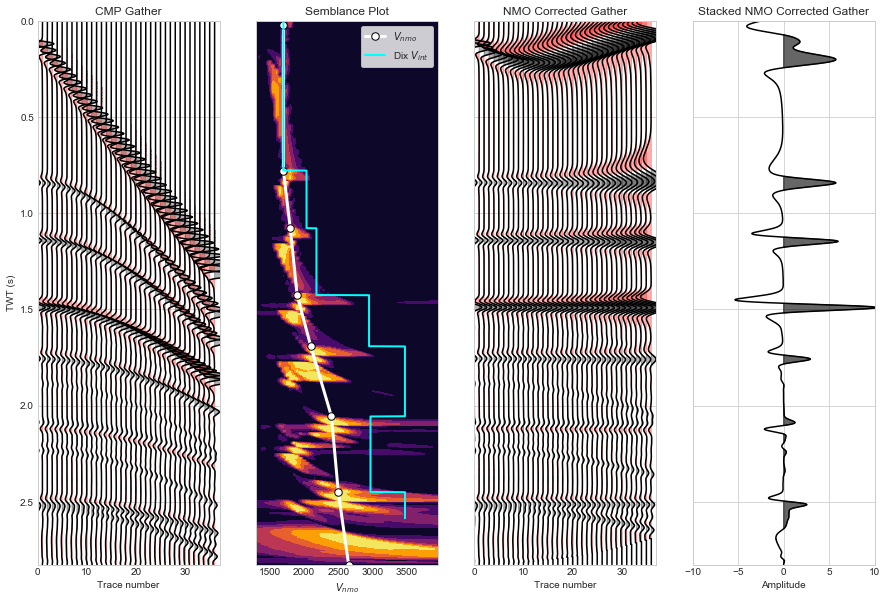

In [66]:
vnmo_correct, twt_vnmo, nmo_corr_gath = interact_plot(1700, 1700, 1800, 1900,2100,2400,2500,2650)

### Making an angle mask which will be used to clip the gather to information we believe is useful.

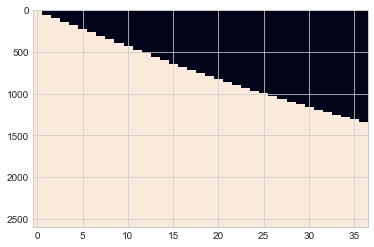

In [77]:
angle_mask = 1 * (angles < 38)
plt.imshow(angle_mask.T, aspect='auto')
angle_filt_gath = nmo_corr_gath * angle_mask.T # creating the clipped gather (still in the offset domain)

## Here I am linearly interpolating between the Vnmo points and then using a Savitzky–Golay filter ([information here](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter)) in order to smooth the results. This will help get rid of sharp jumps when we calculate the incidence angle of the NMO corrected reflections.

C:\Users\goril\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide


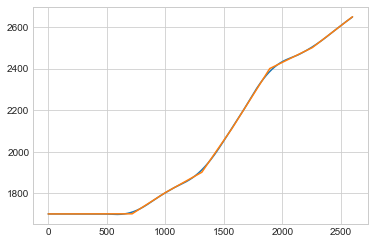

In [90]:
f1 = interp1d(twt_vnmo,
                  vnmo_correct, 
                  fill_value='extrapolate', kind='linear')
vnmo_usr_interp = f1(twt)

from scipy.signal import savgol_filter

vnmo_corr_interp_savgol_filt = savgol_filter(vnmo_usr_interp, 501,3)
plt.plot(vnmo_corr_interp_savgol_filt)
plt.plot(vnmo_usr_interp)


depth = (vnmo_corr_interp_savgol_filt * twt) / 2
# angles = np.array([np.degrees(np.arctan(off / ( 2 * depth))) for off in offsets])
angles = np.array([np.degrees(np.arctan(off / (vnmo_corr_interp_savgol_filt * twt))) for off in offsets])
# angles = 90 - np.degrees(np.arctan(depth / offsets))
# plt.imshow(angles.T, aspect='auto', cmap='jet')
# plt.colorbar()

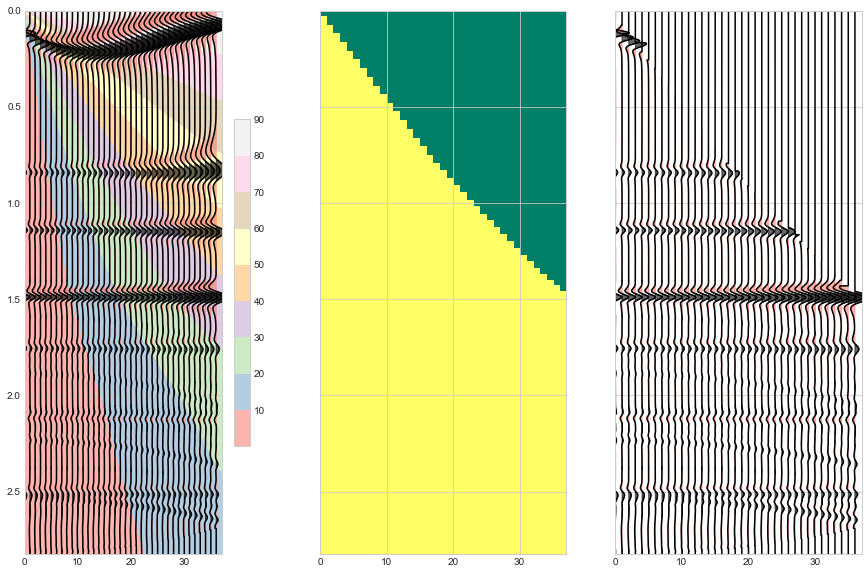

In [78]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,10), sharey=True, sharex=True)

for i,wig in enumerate(nmo_corr_gath.T):
    ax1.plot(wig * gain + i, twt, color='k')
    ax1.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i > i, color='k', alpha=0.6)
    ax1.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i < i, color='salmon', alpha=0.6)
im = ax1.imshow(angles.T, aspect = 'auto', alpha=1, extent=[0,37,twt.max(), 0], cmap='Pastel1', vmax=90, interpolation='bicubic')
plt.colorbar(im, ax=ax1, shrink=0.6)
ax1.set_ylim(twt.max(),0)
ax1.set_xlim(0,37)

im = ax2.imshow(angle_mask.T, aspect = 'auto', alpha=1, extent=[0,37,twt.max(), 0],
                cmap='summer', vmax=1)

for i,wig in enumerate(angle_filt_gath.T):
    ax3.plot(wig * gain + i, twt, color='k')
    ax3.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i > i, color='k', alpha=0.6)
    ax3.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i < i, color='salmon', alpha=0.6)



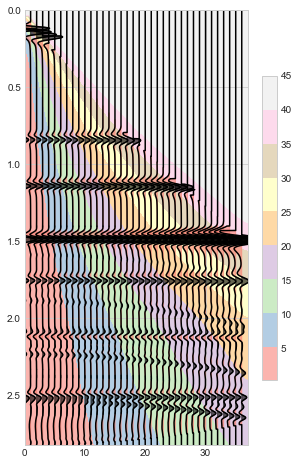

In [79]:
gain=10
plt.figure(figsize=(5,8))

for i,wig in enumerate(angle_filt_gath.T):
    plt.plot(wig * gain + i, twt, color='k')
    plt.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i > i, color='k', alpha=0.6)
    plt.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i < i, color='salmon', alpha=0.6)
plt.gca().invert_yaxis()
plt.imshow(angles.T, aspect = 'auto', alpha=1, extent=[0,37,twt.max(), 0], cmap='Pastel1', vmax=45, interpolation='bicubic')
plt.colorbar(shrink=0.7, )


$$v_{n} = \sqrt{\frac{t_n V_{n}^2 - t_{n-1} V_{n-1}^2}{t_n-t_{n-1}}}$$

In [80]:
interact_manual(interact_plot,
            v0=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1700),
            v1=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1700),
            v2=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1800),
            v3=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1900),
            v4=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2100),
            v5=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2400),
            v6=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2500),
            v7=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2650)
            )

interactive(children=(FloatSlider(value=1700.0, description='v0', max=3950.0, min=1300.0, step=50.0), FloatSli…

<function __main__.interact_plot>

You can see from the above Dix interval velocity looks very similar to the true velocities of the earth model which generated the synthetic CMP we are analyzing.

NameError: name 'dix_vint_blkd' is not defined

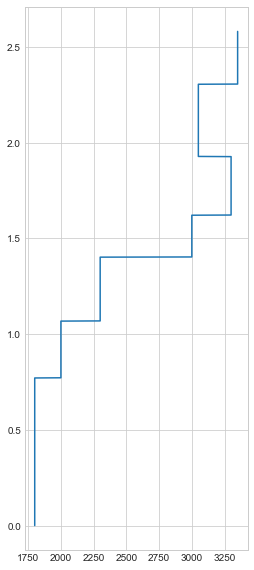

In [82]:
from bruges import transform
sns.set_style('whitegrid')
plt.figure(figsize=(4,10))

true_vel, twt_trans = transform.depth_to_time(cmp_vel_mod[:,1], cmp_vel_mod[:,1], dz=10, dt=0.001, return_t=True)
plt.plot(true_vel, twt_trans, label='Dix Interval Velocity')
plt.plot(dix_vint_blkd, np.arange(0,t_basis.max(),dt), label='Actual Velocity')
plt.ylim(0,2.6)
plt.gca().invert_yaxis()
plt.ylabel('TWT (s)')
plt.xlabel('Velocity (m/s)')
plt.legend(loc=1, frameon=True)

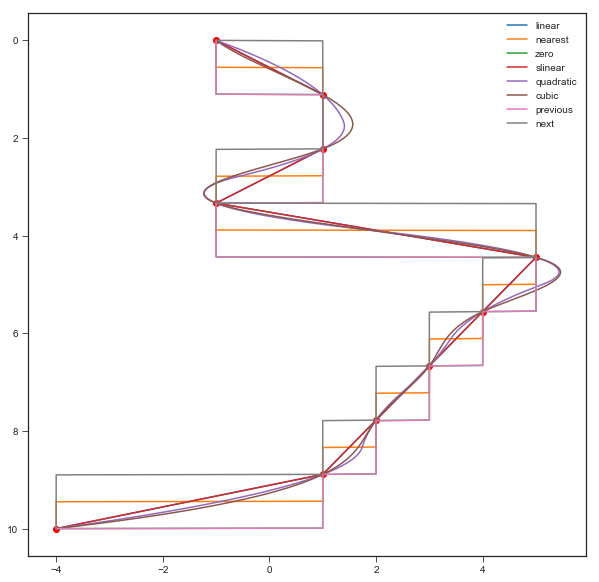

In [391]:
x = np.linspace(0,10,10)
y = np.array([-1,1,1,-1,5,4,3,2,1,-4])

x_new = np.linspace(0,10,1000)

interp_type = ['linear', 'nearest','zero', 'slinear','quadratic', 'cubic','previous', 'next']


    
plt.figure(figsize=(10,10))
for interpl in interp_type:
    z = interp1d(x,y,kind=interpl,)
    zz = z(x_new)
    plt.plot(zz,x_new, label=interpl)
    
plt.scatter(y,x,color='r') 
plt.gca().invert_yaxis()
plt.legend()

array([700, 300, 400, 400, 600, 600, 500])

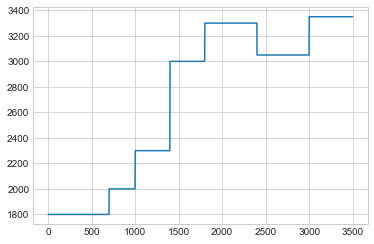

In [278]:
plt.plot(real_vel)
def rms(v,layer):
    l_diff = np.diff(layer)
    rms = [np.sqrt(np.sum(v**2 / l) * np.sum(l)) for v,l in zip(v, layer)]
    return rms
interface_depths = [0, 700, 1000, 1400, 1800, 2400, 3000,3500]
int_vels = [1800, 2000, 2300, 3000, 3300, 3050, 3350]
    
# rms(int_vels, interface_depths)
# plt.plot(interface_depths[:-2],rms(int_vels))
np.diff(interface_depths)

array([0.00000000e+00, 1.08692589e-03, 2.17385177e-03, ...,
       2.68905464e+00, 2.69014157e+00, 2.69122849e+00])

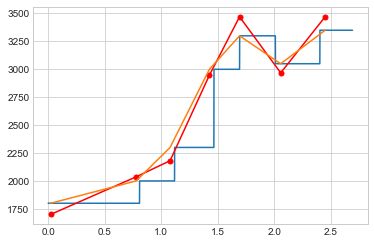

In [244]:
vrms = [1700,1700,1800,1900,2100,2400,2500,2650]
real_vel, twt_vel_mod = vel_mod()
twt_vrms = np.append(twt_vel_mod, twt.max())
interp_type = ['linear', 'nearest','zero', 'slinear','quadratic', 'cubic','previous', 'next']


def dix_eq(vrms, twt):
    int_vel = [np.sqrt((twt[i] * vrms[i]**2 - twt[i-1] * vrms[i-1]**2) / (twt[i] - twt[i-1])) for i in range(1,len(vrms))]
    return int_vel

v_int = dix_eq(vrms, twt_vrms)


# z = interp1d(twt_vrms[:-2],v_int,kind='previous')
# v_int_interp = z(x_new)
# plt.plot(zz,x_new, label=interpl)

t_basis, real_vel_twt = depth_to_time(real_vel, real_vel, dz=1.04,dt=dt,return_t=True)
# x_new=np.linspace(0,twt_vrms[-2],num=len(real_vel_twt))
plt.plot(real_vel_twt, t_basis)
plt.plot(twt_vrms[:-1], dix_eq(vrms, twt_vrms),'.-r', markersize=10)
plt.plot(twt_vel_mod, int_vels)
# plt.plot(twt_vel_mod_1, int_vels)

# plt.plot(x_new, v_int_interp)

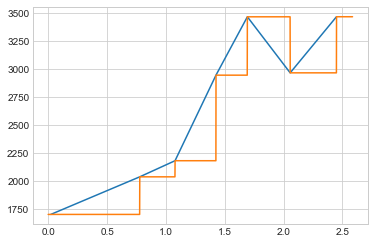

In [307]:
real_vel, twt_vel_mod = vel_mod()
real_vel_twt, t_basis = depth_to_time(real_vel, real_vel, dz=1, dt=dt, return_t=True)
real_vel_twt = real_vel_twt[:cmp_geom_sprd.shape[0]]
t_basis = t_basis[:cmp_geom_sprd.shape[0]]

vnmo_user = [1700,1700,1800,1900,2100,2400,2500,2650]
dix_vint = dix_eq(vnmo_user, np.append(twt_vel_mod, twt.max()))
dix_vint = np.append(dix_vint, dix_vint[-1])
f2 = interp1d(np.append(twt_vel_mod, twt.max()),dix_vint, kind='previous', fill_value='extrapolate')
y_new = np.arange(0,t_basis.max(), dt)
dix_vint_blkd = f2(y_new)

_, t = vel_mod()

plt.plot(t, dix_vint[:-1])
plt.plot()
plt.plot(np.arange(0,t_basis.max(),dt), dix_vint_blkd)
# plt.plot(real_vel_twt, t_basis)

In [325]:
len(dix_vint_blkd)

2380

In [154]:
def v_rms(v,twt):
    t_diff = np.diff(twt)
#     vrms = [np.sqrt((v[i+1]**2 * t_diff[i+1] + v[i]**2 * t_diff[i]) / (t_diff[i+1] + t_diff[i])) for i in np.arange(6)]
#     vrms = np.cumsum(vrms)
    print(t_diff)
    rms = np.sqrt([np.sum((v[i]**2 * t_diff[i]) / np.sum(t_diff[i])) for i in range(len(t_diff))])
    print(rms)
    return rms

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
%matplotlib inline

In [42]:
test_mat = np.zeros((100,100))

In [62]:
for i in range(4):
    step = int(test_mat.shape[0] / 4)
    test_mat[step * (i - 1):step*i, 30:32] = i + 1 * step
    print(step*i)
for i in range(6):
    step = int(test_mat.shape[0] / 6)
    test_mat[step * (i - 1):step*i, 60:62] = i + 1 * step

0
25
50
75


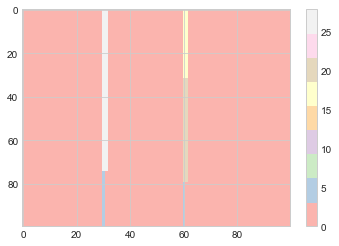

In [63]:
plt.imshow(test_mat, aspect='auto', cmap='Pastel1')
plt.colorbar()

In [65]:
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')

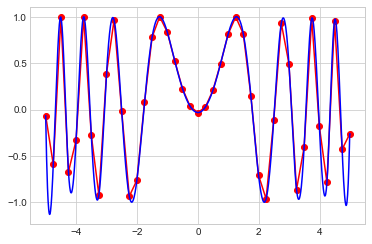

In [68]:
xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

In [31]:
from skimage.transform import radon

plt.imshow(radon(cmp_geom_sprd), aspect='auto')

C:\Users\goril\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:58: UserWarning: The default of `circle` in `skimage.transform.radon` will change to `True` in version 0.15.
  warn('The default of `circle` in `skimage.transform.radon` '


KeyboardInterrupt: 

In [32]:
radon(cmp_geom_sprd, circle=False)

KeyboardInterrupt: 

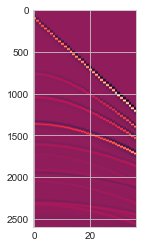

In [40]:
plt.imshow(cmp_geom_sprd, aspect=0.03)

In [46]:
time = 0.250
trace = cmp_geom_sprd[:,10]
before = int(np.floor(time/dt))
samples = np.arange(before - 1, before + 3)
times = dt*samples
amps=trace[samples]
interpolator=CubicSpline(times,amps)
amplitude = interpolator(time)

In [49]:
amplitude

array(3.01857455e-17)

In [50]:
amps

array([1.59257184e-17, 3.00759033e-17, 4.98013515e-17, 7.51754046e-17])

In [53]:
times = np.arange(0,cmp_geom_sprd.shape[0]*dt, dt)


array([0.00000000e+00, 1.08692589e-03, 2.17385177e-03, ...,
       2.82274652e+00, 2.82383345e+00, 2.82492038e+00])

In [55]:
reflection_time(time,300,2500)

0.27730849247724093